In [10]:
# organize imports
from keras.models import Sequential
from keras.layers import Dense
from keras.utils import normalize
from keras.callbacks import Callback
from keras.callbacks import ReduceLROnPlateau
from keras.optimizers import Adam
from keras.models import load_model
from keras.utils import plot_model

from sklearn.model_selection import train_test_split
import keras.backend as K
import numpy as np
import h5py
import os
import matplotlib.pyplot as plt
import random
import pydot
import tensorflow as tf


In [11]:
# seed for reproducing same results
seed = 9
np.random.seed(seed)


# Visualize the training (and test) dataset

### Zero final velocity dataset with only first iterations of GuSTO stored

/usr/local/lib/python3.5/dist-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


Training data
Random i = 466


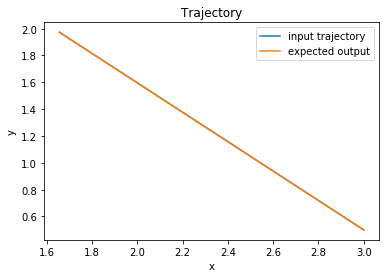

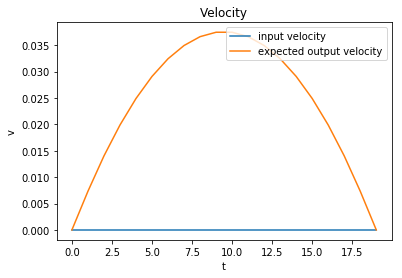

Random i = 419


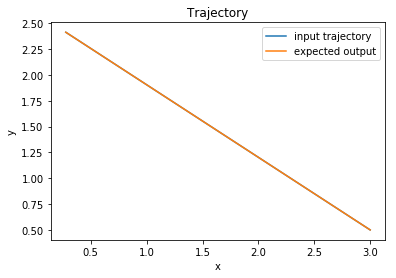

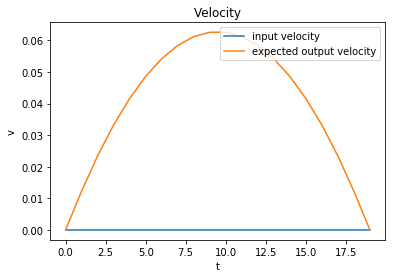

Random i = 370


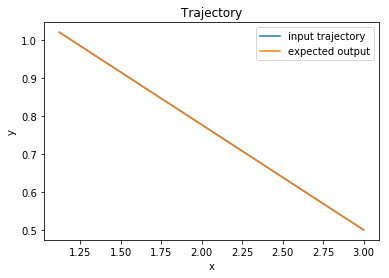

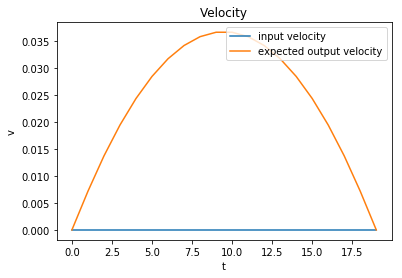

Random i = 196


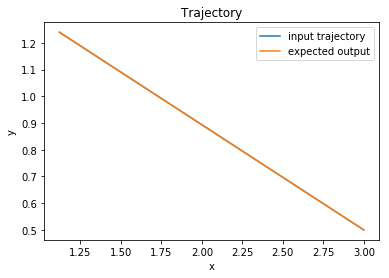

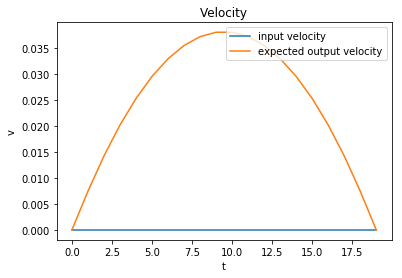

Random i = 212


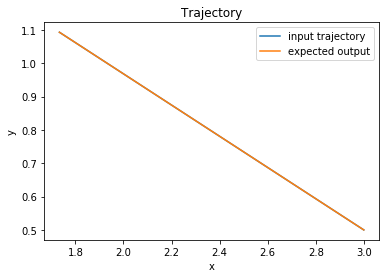

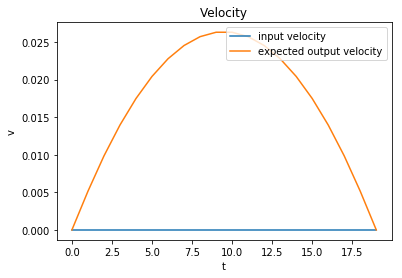

Random i = 425


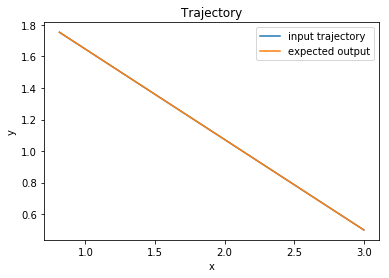

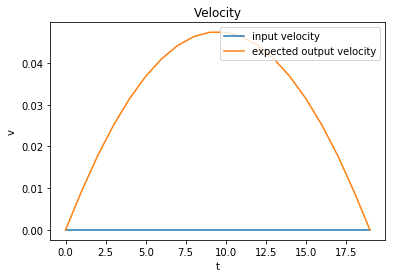

Random i = 81


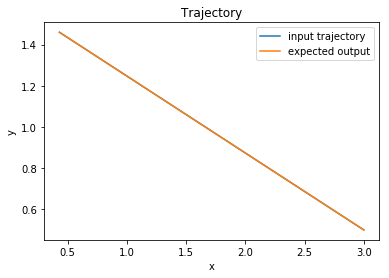

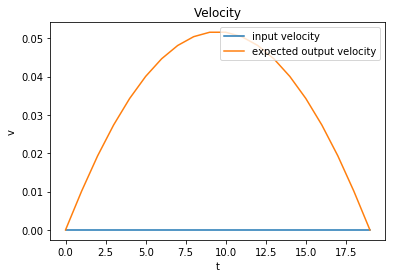

Random i = 192


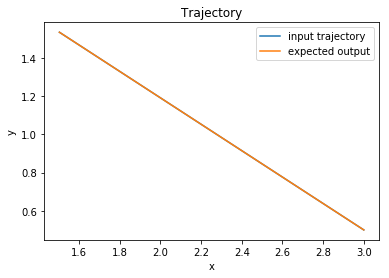

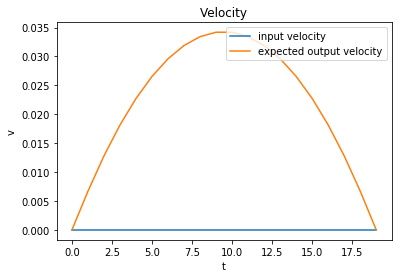

Test data
Random i = 27


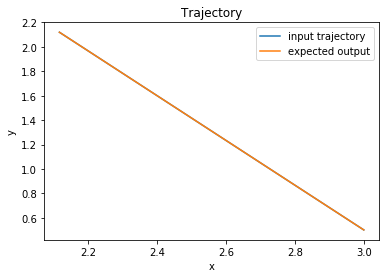

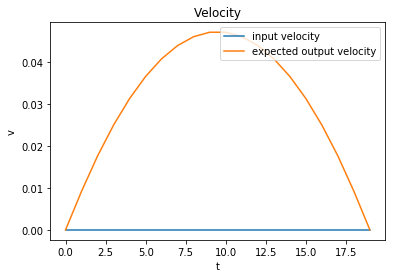

Random i = 22


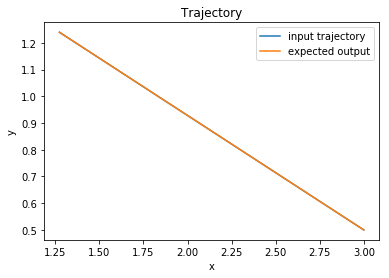

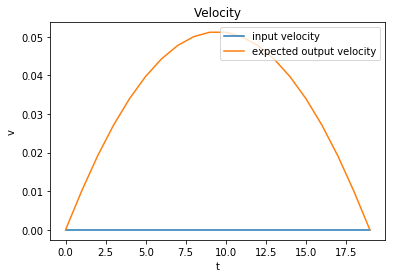

Random i = 12


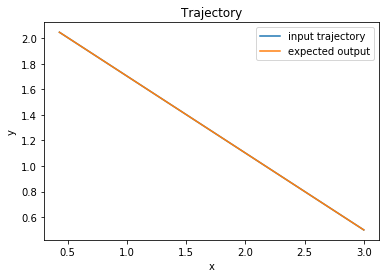

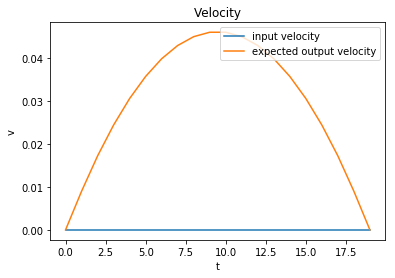

Random i = 155


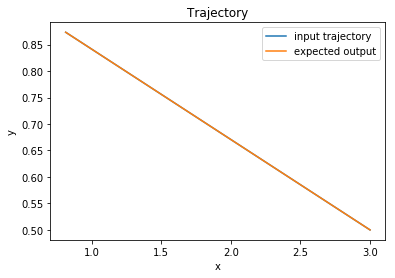

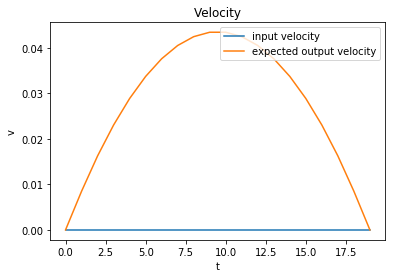

Random i = 93


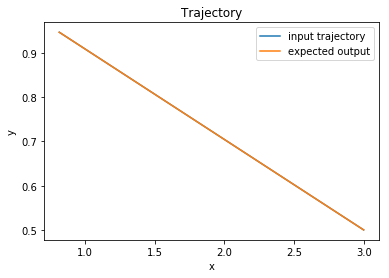

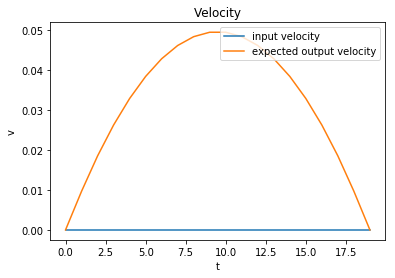

Random i = 97


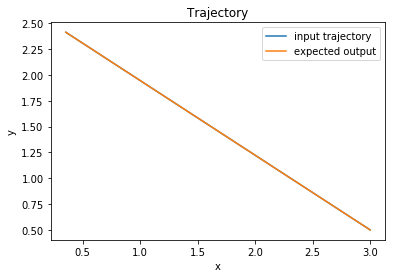

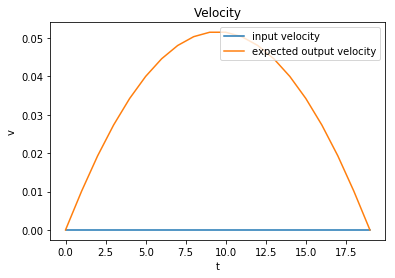

Random i = 159


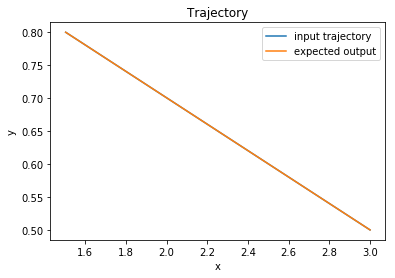

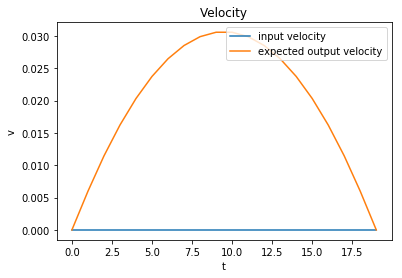

Random i = 139


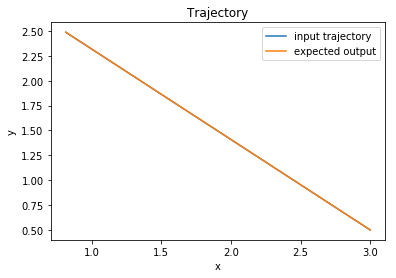

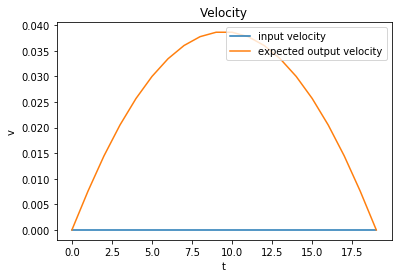

In [12]:
(X_train, X_test, Y_train, Y_test) = loadData(["NoObstacleFirst3IterEndsInOKtf80ZeroFinVelOnly1Iter.jld2"], testRatio = 0.25, fieldNames = ["train_input_collected_first_only", "train_output_collected_first_only"])

print("Training data")
for x in range(8):
    i = random.randint(1,np.size(X_train,0)-1)
    print("Random i =",i)
    plotTrajectoryInputAndOutput(X_train[i,:],Y_train[i,:])
    plotVelocitiesInputAndOutput(X_train[i,:],Y_train[i,:])
print("Test data")
for x in range(8):
    i = random.randint(1,np.size(X_test,0)-1)
    print("Random i =",i)
    plotTrajectoryInputAndOutput(X_test[i,:],Y_test[i,:])
    plotVelocitiesInputAndOutput(X_train[i,:],Y_train[i,:])



## Note that the xy trajectory always remains a straight line and the velocity changes from a constant zero to a parabolic curve

# Try to overfit data! Bigger network and dataset with zero final velocity

In [14]:
(X_train, X_test, Y_train, Y_test) = loadData(["NoObstacleFirst3IterEndsInOKtf80ZeroFinVelOnly1Iter.jld2"], testRatio = 0.25, fieldNames = ["train_input_collected_first_only", "train_output_collected_first_only"])
numSamples = 2
X_train = X_train[1:numSamples,:]
# X_test = X_test[1:4,:]
Y_train = Y_train[1:numSamples,:]
# Y_test = Y_test[1:4,:]

# create the model
model = Sequential()
model.add(Dense(512, input_dim=182, activation='relu'))
model.add(Dense(1024, kernel_initializer='uniform', activation='relu'))
model.add(Dense(512, kernel_initializer='uniform', activation='relu'))
model.add(Dense(1024, kernel_initializer='uniform', activation='relu'))
model.add(Dense(512, kernel_initializer='uniform', activation='relu'))
model.add(Dense(180, kernel_initializer='uniform', activation='relu'))

# compile the model
customAdam = Adam(lr=1e-3, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
model.compile(loss='mean_squared_error', optimizer=customAdam, metrics=['mean_squared_error'])
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1,
                              patience=1, min_lr=1e-50)

lrHist = []

Instructions for updating:
Colocations handled automatically by placer.


In [15]:
# fit the model
histSimple = model.fit(X_train, Y_train, validation_data=(X_test, Y_test), epochs=30, batch_size=1, verbose=1, callbacks=[reduce_lr, CustomMetrics()])

# evaluate the model
scores = model.evaluate(X_test, Y_test)

Instructions for updating:
Use tf.cast instead.
Train on 1 samples, validate on 162 samples
Epoch 1/30
1/1 [==============================] - 2s 2s/step - loss: 0.0020 - mean_squared_error: 0.0020 - val_loss: 0.0025 - val_mean_squared_error: 0.0025
Learning rate:  0.001
Epoch 2/30
1/1 [==============================] - 0s 387ms/step - loss: 0.0014 - mean_squared_error: 0.0014 - val_loss: 0.0024 - val_mean_squared_error: 0.0024
Learning rate:  0.001
Epoch 3/30
1/1 [==============================] - 0s 347ms/step - loss: 0.0014 - mean_squared_error: 0.0014 - val_loss: 0.0023 - val_mean_squared_error: 0.0023
Learning rate:  0.001
Epoch 4/30
1/1 [==============================] - 0s 374ms/step - loss: 0.0012 - mean_squared_error: 0.0012 - val_loss: 0.0022 - val_mean_squared_error: 0.0022
Learning rate:  0.000100000005
Epoch 5/30
1/1 [==============================] - 0s 370ms/step - loss: 0.0012 - mean_squared_error: 0.0012 - val_loss: 0.0022 - val_mean_squared_error: 0.0022
Learning rate:

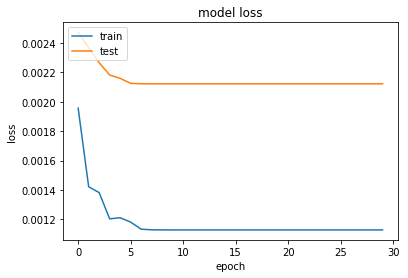

In [16]:
# summarize history for loss
plt.plot(histSimple.history['loss'])
plt.plot(histSimple.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

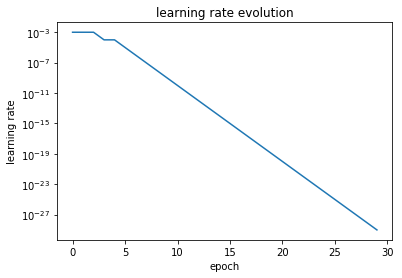

In [17]:
# show evolution of learning rate
plt.plot(lrHist)
plt.title('learning rate evolution')
plt.ylabel('learning rate')
plt.xlabel('epoch')
plt.yscale('log')
plt.show()

In [ ]:
# save model to hdf5 file
# model.save('NoObstacleFirst3IterEndsInOKtf80ZeroFinVelOnly1IterBiggerNetwork.h5') 

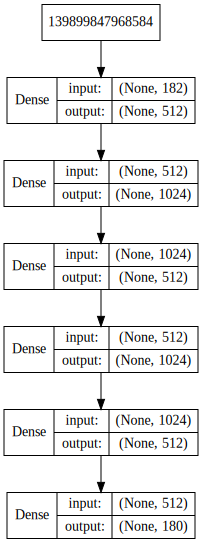

In [23]:
# plot_model(model, to_file='NoObstacleFirst3IterEndsInOKtf80ZeroFinVelOnly1IterBiggerNetwork.png')
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

model = load_model('NoObstacleFirst3IterEndsInOKtf80ZeroFinVelOnly1IterBiggerNetwork.h5')
SVG(model_to_dot(model, show_shapes=True, show_layer_names=False).create(prog='dot', format='svg'))

# Run model on some inputs and plot results

## Newer model, bigger network, first iteration only

### Try training data

In [19]:
model = load_model('NoObstacleFirst3IterEndsInOKtf80ZeroFinVelOnly1IterBiggerNetwork.h5')
(X_train, X_test, Y_train, Y_test) = loadData(["NoObstacleFirst3IterEndsInOKtf80ZeroFinVelOnly1Iter.jld2"], testRatio = 0.25, fieldNames = ["train_input_collected_first_only", "train_output_collected_first_only"])

Idx = [94,78,257]
X_train_np_array=np.array(X_train)
NN_output = model.predict(X_train_np_array[Idx])

/usr/local/lib/python3.5/dist-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


Training Examples


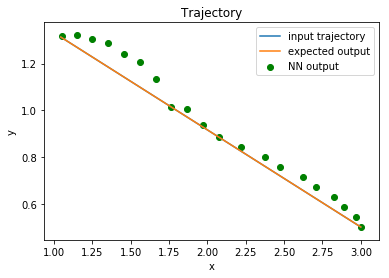

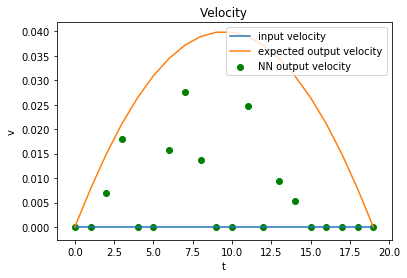

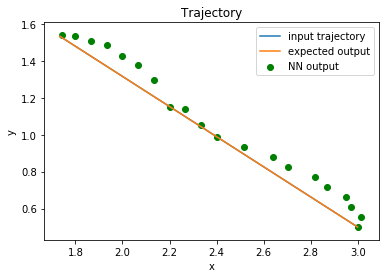

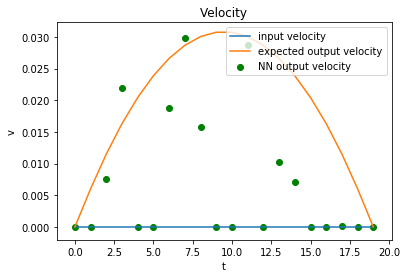

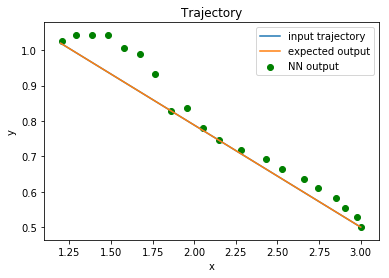

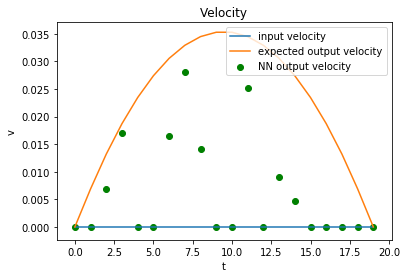

In [20]:
print("Training Examples")
for NN_idx, train_idx in enumerate(Idx):
    plotTrajectoryInputExpectedAndNN(X_train[train_idx,:],Y_train[train_idx,:],NN_output[NN_idx,:])
    plotVelocitiesInputExpectedAndNN(X_train[train_idx,:],Y_train[train_idx,:],NN_output[NN_idx,:])


### Try test data

In [21]:
# model = load_model('NoObstacleFirst3IterOKDecayLRModel.h5')
Idx = [61,83,100, 123]
X_test_np_array=np.array(X_test)
NN_output = model.predict(X_test_np_array[Idx])

(4, 180)
Test Examples


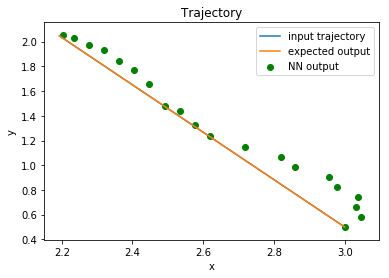

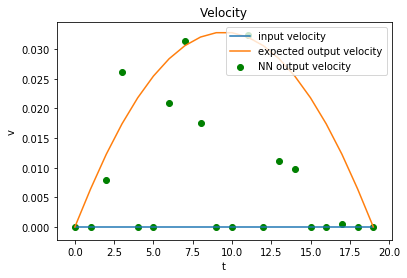

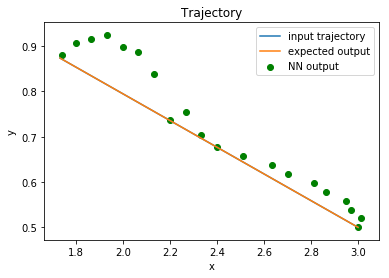

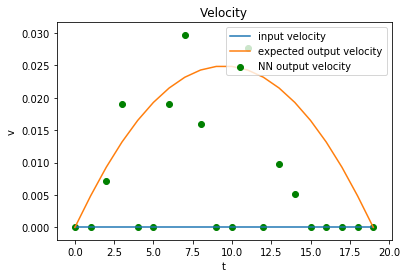

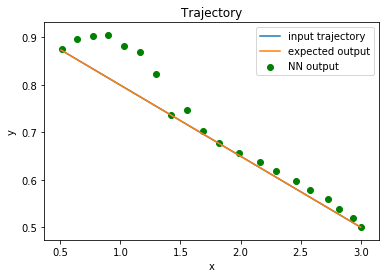

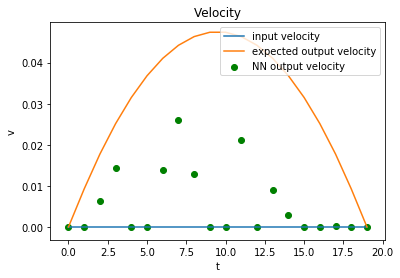

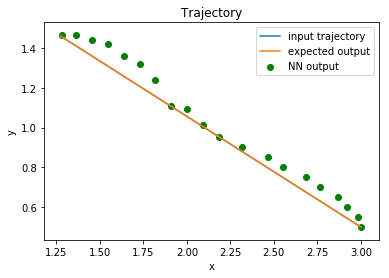

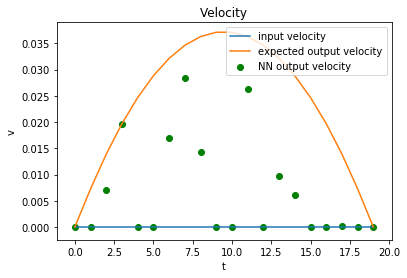

In [22]:
print(np.shape(NN_output))
print("Test Examples")
for NN_idx, test_idx in enumerate(Idx):
    plotTrajectoryInputExpectedAndNN(X_test[test_idx,:],Y_test[test_idx,:],NN_output[NN_idx,:])
    plotVelocitiesInputExpectedAndNN(X_test[test_idx,:],Y_test[test_idx,:],NN_output[NN_idx,:])


# Helper functions below

## Load data and create test and training inputs and outputs

In [3]:
# filenames must be a list
def loadData(filenames, testRatio = 0.25, fieldNames = ["train_input_collected", "train_output_collected"]):
    # load simple dataset
    for i, filename in enumerate(filenames):
        PATH_FILE_TRAINING3 = os.getcwd()+"/"+filename
        f = h5py.File(PATH_FILE_TRAINING3, "r")
        # split into input and output variables
        if i==0:
            X       = f[fieldNames[0]].value;     
            X      = X.transpose();
            Y        = f[fieldNames[1]].value;      
            Y       = Y.transpose();
        else:
            X1       = f[fieldNames[0]].value;     
            X1      = X1.transpose();
            Y1        = f[fieldNames[1]].value;      
            Y1       = Y1.transpose();
            X = np.vstack((X,X1))
            Y = np.vstack((Y,Y1))   
    
    # split the data into training (75%) and testing (25%)
    (X_train, X_test, Y_train, Y_test) = train_test_split(X, Y, test_size=testRatio, random_state=seed)

    # Examine shape of data
#     print(np.shape(X))
#     print(np.shape(Y))
#     print(np.shape(X_train))
#     print(np.shape(X_test))
#     print(np.shape(Y_train))
#     print(np.shape(Y_test))
    return X_train, X_test, Y_train, Y_test



## Create custom metric to print learning rate after each epoch

In [4]:
class CustomMetrics(Callback):
    def on_epoch_end(self, epoch, logs=None):
        current_lr = K.eval(self.model.optimizer.lr)
        lrHist.append(current_lr)
        print("Learning rate: ",current_lr)

## Function to plot trajectory from row of training data

In [5]:
def plotTrajectoryFromInput(X_data):
    # X_data has length 182 ~ 
    # 20 sets of (x,y,theta,xdot,ydot,thetadot) for all N=6 dimensions = 120
    # 20 values of (u1, u2, u3) = 60 
    # + omega,delta = 2
    x = X_data[0:120:6] 
    y = X_data[1:120:6]
#     print(np.shape(x))
#     print(np.shape(y))
    plt.plot(x, y)
    plt.title('Trajectory')
    plt.ylabel('y')
    plt.xlabel('x')
    # plt.legend(['train', 'test'], loc='upper left')
    plt.show()

In [6]:
def plotTrajectoryInputAndOutput(X_data, Y_data):
    # X_data has length 182 ~ 
    # 20 sets of (x,y,theta,xdot,ydot,thetadot) for all N=6 dimensions = 120
    # 20 values of (u1, u2, u3) = 60 
    # + omega,delta = 2
    xIn = X_data[0:120:6] 
    yIn = X_data[1:120:6]
#     print(np.shape(xIn))
#     print(np.shape(yIn))
    
    xOut = xIn + Y_data[0:120:6]
    yOut = yIn + Y_data[1:120:6]
#     print(np.shape(xOut))
#     print(np.shape(yOut))
    
    plt.plot(xIn, yIn)
    plt.plot(xOut, yOut)
    plt.title('Trajectory')
    plt.ylabel('y')
    plt.xlabel('x')
    plt.legend(['input trajectory', 'expected output'], loc='upper right')
    plt.show()

In [7]:
def plotVelocitiesInputAndOutput(X_data, Y_data):
    # X_data has length 182 ~ 
    # 20 sets of (x,y,theta,xdot,ydot,thetadot) for all N=6 dimensions = 120
    # 20 values of (u1, u2, u3) = 60 
    # + omega,delta = 2
    xDotIn = np.array(X_data[3:120:6])
    yDotIn = np.array(X_data[4:120:6])
    velIn = np.sqrt(xDotIn**2 + yDotIn**2)
#     print(np.shape(xIn))
#     print(np.shape(yIn))
    
    xDotOut = np.array(xDotIn + Y_data[3:120:6])
    yDotOut = np.array(yDotIn + Y_data[4:120:6])
    velOut = np.sqrt(xDotOut**2 + yDotOut**2)
#     print(np.shape(xOut))
#     print(np.shape(yOut))
    
    plt.plot(velIn)
    plt.plot(velOut)
    plt.title('Velocity')
    plt.ylabel('v')
    plt.xlabel('t')
    plt.legend(['input velocity', 'expected output velocity'], loc='upper right')
    plt.show()

In [8]:
def plotTrajectoryInputExpectedAndNN(X_data, Y_data, NN_data):
    # X_data has length 182 ~ 
    # 20 sets of (x,y,theta,xdot,ydot,thetadot) for all N=6 dimensions = 120
    # 20 values of (u1, u2, u3) = 60 
    # + omega,delta = 2
    xIn = X_data[0:120:6] 
    yIn = X_data[1:120:6]
#     print(np.shape(xIn))
#     print(np.shape(yIn))
    
    xExp = xIn + Y_data[0:120:6]
    yExp = yIn + Y_data[1:120:6]
#     print(np.shape(xOut))
#     print(np.shape(yOut))

    xNN = xIn + NN_data[0:120:6]
    yNN = yIn + NN_data[1:120:6]
    
    plt.plot(xIn, yIn)
    plt.plot(xExp, yExp)
    plt.scatter(xNN, yNN,color='g')
    plt.title('Trajectory')
    plt.ylabel('y')
    plt.xlabel('x')
    plt.legend(['input trajectory', 'expected output', 'NN output'], loc='upper right')
    plt.show()

In [9]:
def plotVelocitiesInputExpectedAndNN(X_data, Y_data, NN_data):
    # X_data has length 182 ~ 
    # 20 sets of (x,y,theta,xdot,ydot,thetadot) for all N=6 dimensions = 120
    # 20 values of (u1, u2, u3) = 60 
    # + omega,delta = 2
    xDotIn = np.array(X_data[3:120:6])
    yDotIn = np.array(X_data[4:120:6])
    velIn = np.sqrt(xDotIn**2 + yDotIn**2)
#     print(np.shape(xIn))
#     print(np.shape(yIn))
    
    xDotExp = np.array(xDotIn + Y_data[3:120:6])
    yDotExp = np.array(yDotIn + Y_data[4:120:6])
    velExp = np.sqrt(xDotExp**2 + yDotExp**2)
#     print(np.shape(xOut))
#     print(np.shape(yOut))
    xDotNN = np.array(xDotIn + NN_data[3:120:6])
    yDotNN = np.array(yDotIn + NN_data[4:120:6])
    velNN = np.sqrt(xDotNN**2 + yDotNN**2)
    
    plt.plot(velIn)
    plt.plot(velExp)
    plt.scatter(np.arange(np.size(velNN,0)), velNN,color='g')
    plt.title('Velocity')
    plt.ylabel('v')
    plt.xlabel('t')
    plt.legend(['input velocity', 'expected output velocity', 'NN output velocity'], loc='upper right')
    plt.show()